In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('../'))
import IPython
import IPython.display
import numpy as np
import random
import pandas as pd
import tensorflow as tf
from andi_datasets.datasets_phenom import datasets_phenom

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2024-05-16 13:52:37.409513: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-16 13:52:37.409556: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-16 13:52:37.409571: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-16 13:52:37.413550: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.14.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-05-16 13:52:38.726362: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-16 13:52:38.728983: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-16 13:52:38.729012: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.


In [2]:
WINDOW_WIDTHS = np.arange(10, 100, 2)
SHIFT_WIDTH = 40
JUMP_D = 5

In [3]:
def uncumulate(xs:np.ndarray):
    assert xs.ndim == 1
    uncum_list = [0.]
    for i in range(1, len(xs)):
        uncum_list.append(xs[i] - xs[i-1])
    return np.array(uncum_list)

In [4]:
def make_signal(x_pos, y_pos, win_widths):
    all_vals = []
    for win_width in win_widths:
        if win_width >= len(x_pos):
            continue
        vals = []
        for checkpoint in range(int(win_width/2), len(x_pos) - int(win_width/2)):
            xs = x_pos[checkpoint - int(win_width/2) : checkpoint + int(win_width/2)]
            ys = y_pos[checkpoint - int(win_width/2) : checkpoint + int(win_width/2)]

            xs1 = xs[:int(len(xs)/2)] - float(xs[:int(len(xs)/2)][0])
            xs2 = xs[int(len(xs)/2):] - float(xs[int(len(xs)/2):][0])

            ys1 = ys[:int(len(ys)/2)] - float(ys[:int(len(ys)/2)][0])
            ys2 = ys[int(len(ys)/2):] - float(ys[int(len(ys)/2):][0])

            std_xs1 = np.std(xs1)
            std_xs2 = np.std(xs2)
            std_ys1 = np.std(ys1)
            std_ys2 = np.std(ys2)

            surface_xs1 = abs(np.sum(xs1)) / win_width
            surface_xs2 = abs(np.sum(xs2)) / win_width
            surface_ys1 = abs(np.sum(ys1)) / win_width
            surface_ys2 = abs(np.sum(ys2)) / win_width


            xs1 = np.cumsum(abs(xs1)) #* surface_xs1
            xs2 = np.cumsum(abs(xs2)) #* surface_xs2
            ys1 = np.cumsum(abs(ys1)) #* surface_ys1
            ys2 = np.cumsum(abs(ys2)) #* surface_ys2


            xs_max_val = max(np.max(abs(xs1)), np.max(abs(xs2)))
            xs1 = xs1 / xs_max_val
            xs2 = xs2 / xs_max_val
            xs1 = xs1 / win_width
            xs2 = xs2 / win_width

            ys_max_val = max(np.max(abs(ys1)), np.max(abs(ys2)))
            ys1 = ys1 / ys_max_val
            ys2 = ys2 / ys_max_val
            ys1 = ys1 / win_width 
            ys2 = ys2 / win_width

            vals.append(abs(np.sum(xs1 - xs2 + ys1 - ys2)) 
                       * (max(std_xs1, std_xs2) / min(std_xs1, std_xs2)) 
                             * (max(std_ys1, std_ys2) / min(std_ys1, std_ys2)))

        vals = np.concatenate((np.ones(int(win_width/2)) * 0, vals))
        vals = np.concatenate((vals, np.ones(int(win_width/2)) * 0))
        vals = np.array(vals)
        all_vals.append(vals)
    
    all_vals = np.array(all_vals) + 1e-7
    normalized_vals = all_vals.copy()
    for i in range(len(normalized_vals)):
            normalized_vals[i] = normalized_vals[i] / np.max(normalized_vals[i])
    return all_vals, normalized_vals

In [5]:
def compress_signals(signals):
    compressed_signal = []
    nb_signal = signals.shape[1]
    
    for row in signals.transpose():
        nb_activ_window = np.sum(row >= 0)
        if nb_activ_window != 0:
            comp = np.sum(row[row >= 0]) / nb_activ_window
        else:
            comp = 1e-7
        compressed_signal.append(comp)
    compressed_signal = (np.array(compressed_signal) - float(np.min(compressed_signal))) / np.max(compressed_signal)
    return compressed_signal

In [6]:
def slice_data(signal_seq, jump_d, ext_width):
    slice_d = []
    indice = []
    for i in range(ext_width, signal_seq.shape[1] - ext_width, jump_d):
        crop = signal_seq[:, i - SHIFT_WIDTH//2: i + SHIFT_WIDTH//2]
        if crop.shape[1] != SHIFT_WIDTH:
            crop = np.hstack((crop, np.zeros((crop.shape[0], SHIFT_WIDTH - crop.shape[1])) ))
        slice_d.append(crop)
        indice.append(i)
    return np.array(slice_d), np.array(indice) - ext_width

In [7]:
def merge_close_points(changepoints, signal, pred_probas, seuil=5):
    seq_sums = []
    #val_orders = np.argsort(np.sum(signal[:, changepoints], axis=0))[::-1]
    val_orders = np.argsort(pred_probas)[::-1]
    
    filtered_cps = []
    all_cps_range = set()
    for cp in changepoints[val_orders]:
        regis_cp_range = np.arange(-seuil + cp, seuil + cp)
        if len(set(regis_cp_range) & all_cps_range) == 0:
            filtered_cps.append(cp)
            all_cps_range.update(regis_cp_range)
    filtered_cps = np.array(filtered_cps)
    return filtered_cps

In [8]:
def signal_from_extended_data(x, y, win_widths, ext_width, jump_d):
    datas = []
    for data in [x, y]:
        delta_prev_data = -uncumulate(data[:min(data.shape[0], ext_width)])
        delta_prev_data[0] += float(data[0])
        prev_data = np.cumsum(delta_prev_data)[::-1]

        delta_next_data = -uncumulate(data[data.shape[0] - min(data.shape[0], ext_width):][::-1])
        delta_next_data[0] += float(data[-1])
        next_data = np.cumsum(delta_next_data)

        ext_data = np.concatenate((prev_data, data))
        ext_data = np.concatenate((ext_data, next_data))
        datas.append(ext_data)

    signal, norm_signal = make_signal(datas[0], datas[1], win_widths)
    sliced_signals, slice_indice = slice_data(signal, jump_d, min(data.shape[0], ext_width))

    return (signal[:, delta_prev_data.shape[0]:signal.shape[1] - delta_next_data.shape[0]],
            norm_signal[:, delta_prev_data.shape[0]:signal.shape[1] - delta_next_data.shape[0]],
           sliced_signals,
           slice_indice,
           signal)

In [9]:
def ana_cp_predict(model, x, y, win_widths, jump_d, check_proba=False):
    cps = []
    if x.shape[0] <  win_widths[0]:
        return cps

    signal, norm_signal, input_signals, indice, ext_signal = signal_from_extended_data(x, y,
                                                                                       win_widths,
                                                                                       win_widths[-1]//2,
                                                                                       jump_d)

    input_signals = np.array(input_signals).reshape(-1, input_signals.shape[1], SHIFT_WIDTH, 1)
    feat1 = np.array([np.mean(signal, axis=1)**2 / np.std(signal, axis=1)**2] * input_signals.shape[0])
    feat1 = feat1.reshape(-1, input_signals.shape[1], 1, 1)
    
    if input_signals.shape[0] != 0:
        pred = model.predict([input_signals, feat1], verbose=0).flatten()
        cps = indice[pred >= 0.5]  

    if len(cps) == 0:
        return cps

    reg_inputs = input_signals[cps//jump_d,:,:,:]
    reg_inputs = np.array(reg_inputs).reshape(-1, signal.shape[0], SHIFT_WIDTH, 1)
    reg_outputs = regression_model.predict(reg_inputs, verbose=0).flatten()
    
    app_indice = np.argwhere(abs(reg_outputs) < jump_d*2).flatten()
    cps = cps[app_indice]
    reg_outputs = reg_outputs[app_indice]
    cps = np.round(cps + reg_outputs).astype(int)

    input_signals = []
    indices = []
    cps_doublecheck = []
    for cp_check in cps:
        if cp_check <= 0 or cp_check >= x.shape[0]:
            continue
        indices.append(cp_check)
        input_signals.append(ext_signal[:, min(x.shape[0], win_widths[-1]//2) + cp_check - SHIFT_WIDTH//2:
                              min(x.shape[0], win_widths[-1]//2) + cp_check + SHIFT_WIDTH//2])

    if len(indices) == 0:
        return []
    input_signals = np.array(input_signals)
    input_signals = input_signals.reshape(-1, input_signals.shape[1], SHIFT_WIDTH, 1)
    feat1 = np.array([np.mean(signal, axis=1)**2 / np.std(signal, axis=1)**2] * input_signals.shape[0])
    feat1 = feat1.reshape(-1, input_signals.shape[1], 1, 1)

    if input_signals.shape[0] != 0:
        pred = model.predict([input_signals, feat1], verbose=0).flatten()
        cps_doublecheck = np.array(indices)[np.argwhere(pred >= 0.5).flatten()]
    
    if len(cps_doublecheck) > 0:
        cps_doublecheck = merge_close_points(np.array(cps_doublecheck), signal, pred_probas, seuil=10)
    return np.sort(cps_doublecheck)

# Produce results

In [10]:
model_num = 18
classification_model = tf.keras.models.load_model(f'./models/{model_num}/cls_model_{SHIFT_WIDTH}_2.keras')
regression_model = tf.keras.models.load_model(f'./models/{model_num}/reg_model_{SHIFT_WIDTH}_2.keras')

2024-05-16 13:52:44.085696: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-16 13:52:44.085766: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-16 13:52:44.085783: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-16 13:52:44.214176: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-16 13:52:44.214216: I tensorflow/compile

In [11]:
import os
public_data_path = f'public_data_validation_v1/' # make sure the folder has this name or change it
path_results = f'res_valid{model_num}/'
if not os.path.exists(path_results):
    os.makedirs(path_results)

N_EXP = 13
N_FOVS = 30

In [13]:
from andi_datasets.utils_videos import import_tiff_video
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(0)

video = import_tiff_video(public_data_path+'track_1/exp_0/videos_fov_1.tiff')

[  1  10  21  24  25  26  33  37  38  41 255]


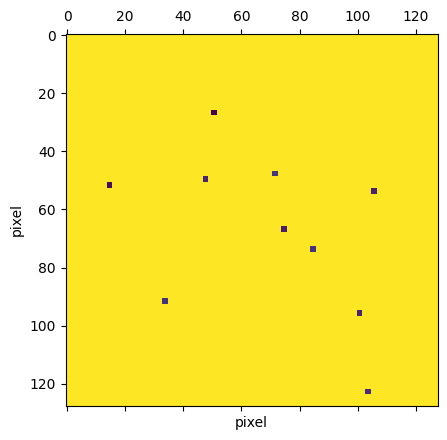

In [14]:
print(np.unique(video[0]))
plt.matshow(video[0])
plt.xlabel('pixel');plt.ylabel('pixel');

In [15]:
for track in [1,2]:
    
    # Create the folder of the track if it does not exists
    path_track = path_results + f'track_{track}/'
    if not os.path.exists(path_track):
        os.makedirs(path_track)
        
    for exp in range(N_EXP):
        # Create the folder of the experiment if it does not exits
        path_exp = path_track+f'exp_{exp}/'
        if not os.path.exists(path_exp):
            os.makedirs(path_exp)
        file_name = path_exp + 'ensemble_labels.txt'
        
        with open(file_name, 'a') as f:
            # Save the model (random) and the number of states (2 in this case)
            model_name = np.random.choice(datasets_phenom().avail_models_name, size = 1)[0]
            f.write(f'model: {model_name}; num_state: {2} \n')

            # Create some dummy data for 2 states. This means 2 columns
            # and 5 rows
            data = np.random.rand(5, 2)
            
            data[-1,:] /= data[-1,:].sum()

            # Save the data in the corresponding ensemble file
            np.savetxt(f, data, delimiter = ';')

In [12]:
# Define the number of experiments and number of FOVS
print(f'Model number: {model_num}')
for track in [1, 2]:
    path_track = path_results + f'track_{track}/'
    #for exp in range(N_EXP):
    for exp in range(N_EXP):
        print(f'Track: {track}, Exp: {exp}')
        path_exp = path_track + f'exp_{exp}/'
        for fov in range(N_FOVS):
            # We read the corresponding csv file from the public data and extract the indices of the trajectories:
            if track == 2:
                df = pd.read_csv(public_data_path + f'track_{track}/exp_{exp}/trajs_fov_{fov}.csv')
            else:
                df = pd.read_csv(public_data_path + f'track_{track}/exp_{exp}/videos_fov_{fov}_track.csv')
            traj_idx = np.sort(df.traj_idx.unique())
            submission_file = path_exp + f'fov_{fov}.txt'

            with open(submission_file, 'w') as f:

                # Loop over each index
                for idx in traj_idx:

                    # Get the lenght of the trajectory
                    x = np.array(df[df.traj_idx == idx])[:, 2]
                    y = np.array(df[df.traj_idx == idx])[:, 3]
                    length_traj = df[df.traj_idx == idx].shape[0]


                    try:
                        cps = ana_cp_predict(classification_model, x, y, WINDOW_WIDTHS, JUMP_D)
                    except Exception as e:
                        print(f'err at track:{track}, exp:{exp}, fov:{fov}, idx:{idx}')
                        print(e)
                        print(f'-----------------------------------------------------')
                        cps = []
                        
                    cps = np.concatenate((cps, [length_traj])).astype(int)
                    prediction_traj = [idx.astype(int)]
                    for k, alpha, state, cp in zip([99999999] * len(cps), [99999999] * len(cps),
                                                   [99999999] * len(cps), cps):
                        prediction_traj.append(k)
                        prediction_traj.append(alpha)
                        prediction_traj.append(state)
                        prediction_traj.append(cp)

                    formatted_numbers = ','.join(map(str, prediction_traj))
                    f.write(formatted_numbers + '\n')

Track: 2, Exp: 3


2024-05-16 13:52:51.337365: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700


Track: 2, Exp: 4
Track: 2, Exp: 5
Track: 2, Exp: 6
Track: 2, Exp: 7
Track: 2, Exp: 8
Track: 2, Exp: 9
Track: 2, Exp: 10
Track: 2, Exp: 11
Track: 2, Exp: 12
